## Feature Extraction toolbox

In [117]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
import mat73
from scipy.io import loadmat, savemat
import mne
#conda install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import random

In [202]:
#loadmats (chlabels, fs, values)
values = mat73.loadmat('/Users/carlosaguila/Downloads/values_HUP100.mat')
values = values['values_all']
select_spikes = loadmat('/Users/carlosaguila/Downloads/randi_HUP100.mat')
select_spikes = select_spikes['select_spikes']
chlabels = loadmat('/Users/carlosaguila/Downloads/chlabels_HUP100.mat')
chlabels = chlabels['ch_labels_all']
fs_all = loadmat('/Users/carlosaguila/Downloads/fs_HUP100.mat')
fs_all = fs_all['fs_all']


In [201]:
#code that checks the size of the new matrices
print(np.shape(values))
print(np.shape(random.choice(np.transpose(values[235]))))
print(np.shape(values[235]))
print(np.shape(chlabels))
print((select_spikes[0,2])) #first idx is the spike, second idx is the property.
#[spike idx, channel, run idx, file idx, spike_start, run_time_start, run_time_end]

(500, 2001, 125)
(2001,)
(2001, 125)
()
250.0


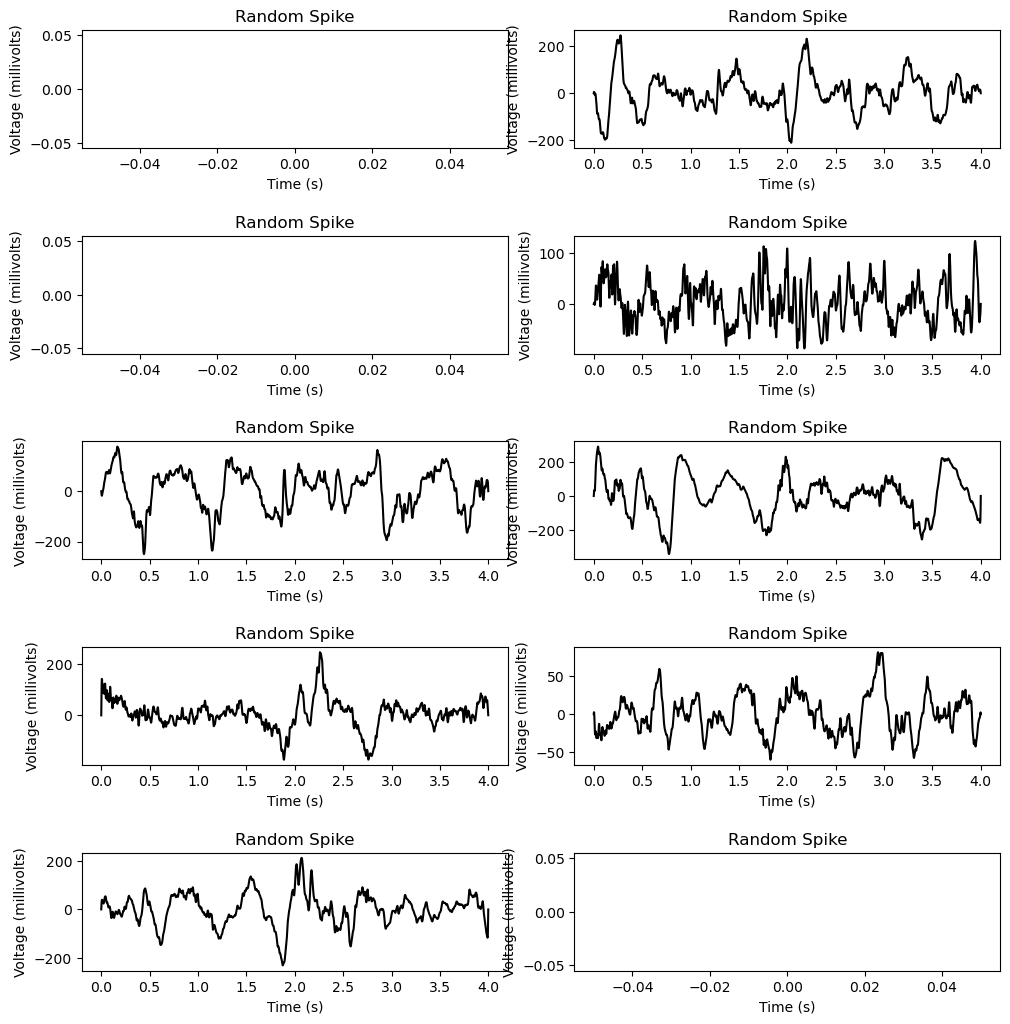

In [52]:
#function that takes random value matrix and plots
def plot_rand_spikes(values):
    plot_idx = range(5)
    fig, axs = plt.subplots(len(plot_idx), 2, figsize=(10,10))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.74)

    time = np.linspace(0,4,2001)
    for i in plot_idx:
        
        choice1 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice2 = random.choice(np.transpose(values[choice1])) #picks what spike to plot in run_time
        
        choice3 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice4 = random.choice(np.transpose(values[choice3])) #picks what spike to plot in run_time
        
        axs[i,0].plot(time, choice2, 'k') #plot nerve data - unfiltered
        axs[i,0].set_ylabel("Voltage (millivolts)")
        axs[i,0].set_xlabel("Time (s)")
        axs[i,0].set_title("Random Spike")
        
        axs[i,1].plot(time, choice4,'k') #plot new axs. 
        axs[i,1].set_ylabel("Voltage (millivolts)")
        axs[i,1].set_xlabel("Time (s)")
        axs[i,1].set_title("Random Spike")

    return

plot_rand_spikes(values)

316


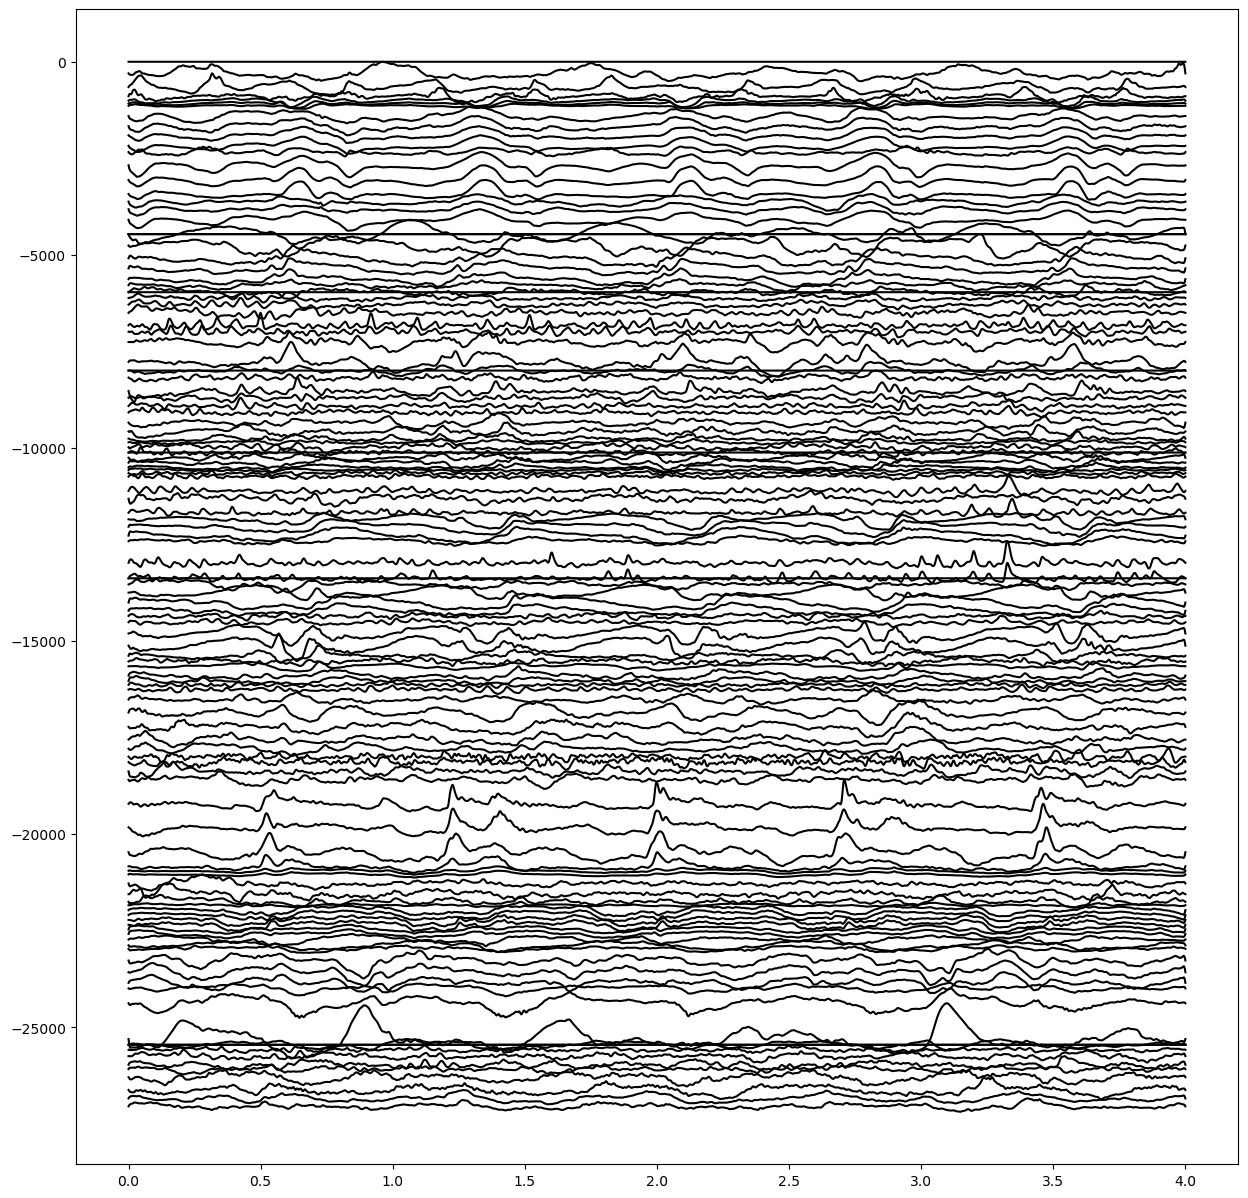

In [159]:
#function that takes random matrix, and plots down the channels
def plot_rand_eeg(values):
    set = random.choice(range(len(values)))
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
    
    return set


print(plot_rand_eeg(values))

304


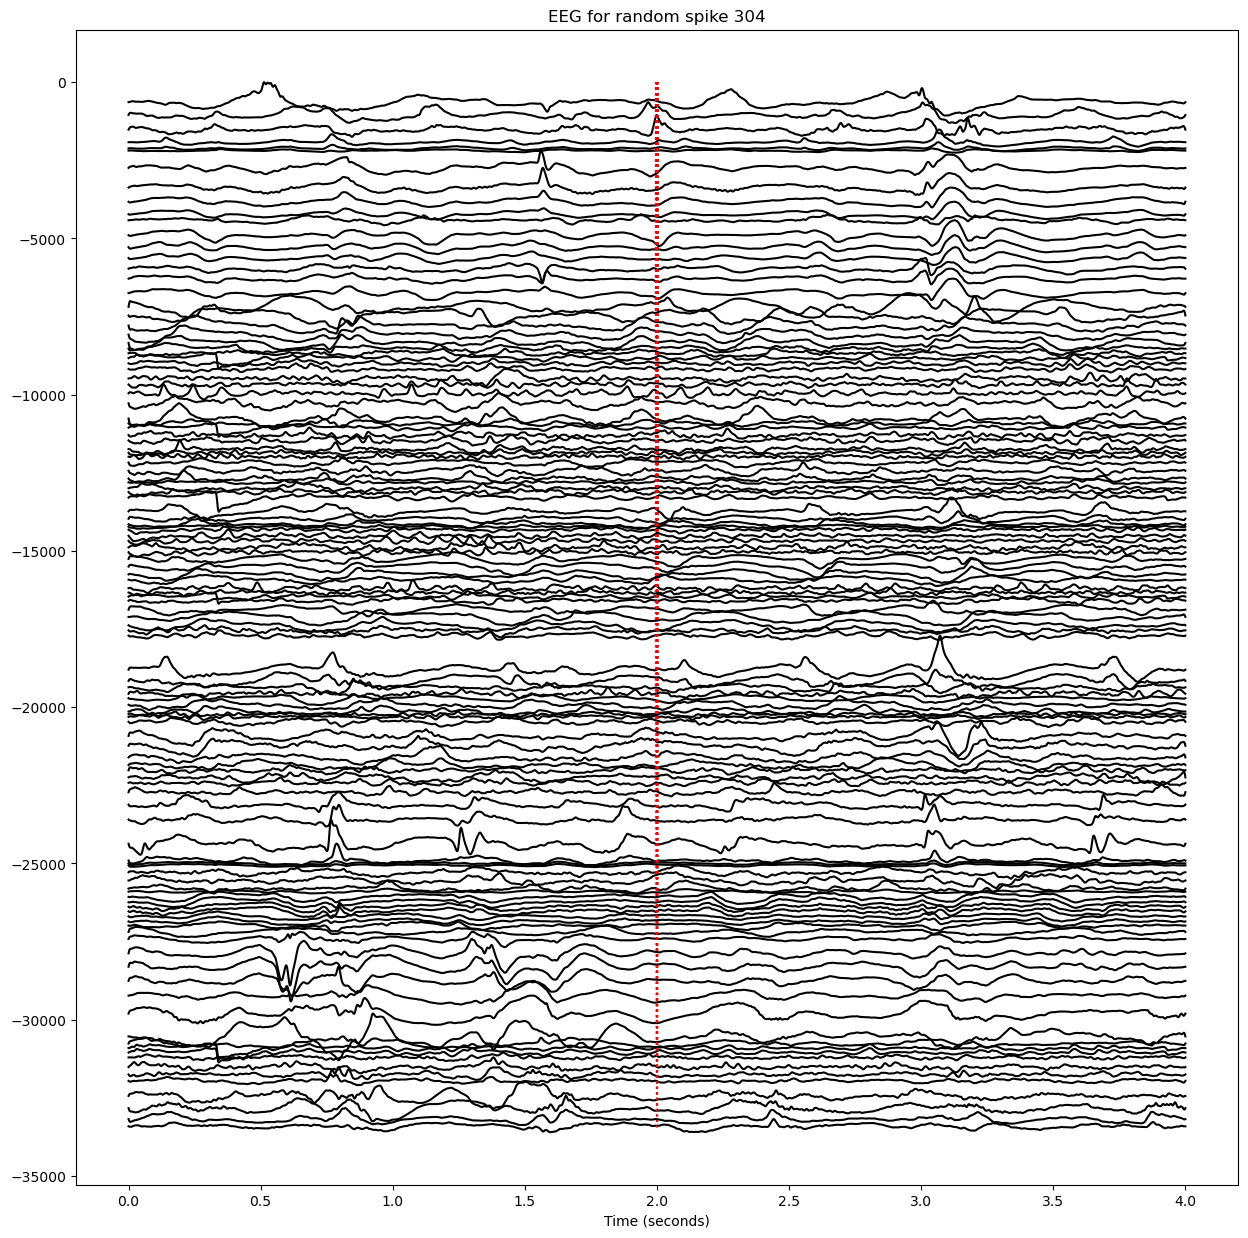

In [183]:
#function that takes random matrix, and plots down the channels
def plot_eeg(values, set):
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        if math.isnan(np.mean(val)) == True:
            continue
        #val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
        plt.title('EEG for random spike {}'.format(set))
        plt.xlabel('Time (seconds)')
        plt.vlines(2,0,-offset-100,colors='r',linestyles='dotted')
    
    return set

print(plot_eeg(values,304))

In [217]:
# line length
def LL(x):
    return np.sum(np.absolute(np.ediff1d(x)))

# energy
def E(x):
    return np.sum(x ** 2)

#RMS
def RMS(x):
    return np.sqrt(np.mean(x**2))

# area
def A(x):
    return np.sum(np.absolute(x))

# spectral amp
def spectral_amplitude(x):
    x_fft = np.fft.fft(x)
    return np.mean(x_fft)

def mean_amplitude_freq(X, fs, lF, uF):
    time_step = 1/fs
    ps = np.abs(np.fft.fft(X)) ** 2
    freqs = np.fft.fftfreq(X.size, time_step)
    mask = np.logical_and(freqs >= lF, freqs <= uF )
    avgValue = ps[mask].mean()
    return avgValue

# number of crossings (zero) - not in
def ZX(x):
    x_demean = x - np.mean(x)
    num_crossings = 0
    for i in range(1, len(x)):
        fromAbove = False
        fromBelow = False
        if x_demean[i - 1] > 0 and x_demean[i] < 0:
            fromAbove = True
        if x_demean[i - 1] < 0 and x_demean[i] > 0:
            fromBelow = True

        if fromAbove or fromBelow:
            num_crossings += 1
    return num_crossings

def MEAN(x):
    return np.mean(x)

def bandpower(x, fs, fmin, fmax):
    f, Pxx = sig.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [227]:
#function to apply feature extraction to a single matrix
def create_feat_list(values):
    feats = []
    for val in values:
        feat_per_spike = []
        val_t = val.transpose()
        for list in val_t:
            list = [0 if math.isnan(x) else x for x in list]
            maxes = np.max(np.absolute(list[750:1251])) #calculate max values around peak
            linelen = LL(list)
            area = A(list)
            feat_per_spike.append([maxes,linelen, area])
        feats.append(feat_per_spike)
    
    return feats

In [239]:
feats = create_feat_list(values)

In [251]:
def find_spike_ch(select_spikes,values):
    #this function will find the values for the spiking channel.
    #should return a 1000 x #ofsamples matrix

    select_spikes_ch = []
    for spikes in select_spikes:
        ch = spikes[1]
        ch = int(ch)-1
        select_spikes_ch.append(ch)
    
    spike_value_all = []
    for i in range(np.size(values,0)):
        val = values[i]
        val_t = val.transpose()
        spike_value = val_t[select_spikes_ch[i]]
        spike_value_all.append(spike_value)

    return select_spikes_ch, spike_value_all #list of spiking channels, list of values for each spiking channel.

In [252]:
select_spikes_ch, spike_value_all = find_spike_ch(select_spikes,values)

In [254]:
print(np.shape(spike_value_all))

(1000, 2001)


In [ ]:
def 